<a href="https://colab.research.google.com/github/taliafabs/STA496/blob/main/MidtermPaper/code/STA496_MidtermPaperCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA496 Midterm Paper Code

In [ ]:
# Workplace setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pymc as pm
import arviz as az
import random
from scipy import stats
from scipy.stats.distributions import chi2

## Data

### Load data

In [ ]:
# ces 2024
# url = "https://raw.githubusercontent.com/taliafabs/STA496/f2606bb9f82da6cc538e5f02998c73ee75dd13c7/MidtermPaper/data/ces24_analysis_data.parquet"
url = "https://github.com/taliafabs/STA496/raw/main/MidtermPaper/data/ces24_analysis_data.parquet"
ces24_df = pd.read_parquet(url, engine="pyarrow")

# split race into Black, white, hispanic, and other
# same approach as kuriwaki et al
# ces24_df['race'].value_counts()
race_map = {
    'White': 'White',
    'Black': 'Black',
    'Hispanic': 'Hispanic',
    'Asian': 'All Other Races',
    'Two or more races': 'All Other Races',
    'Other': 'All Other Races',
    'Native American': 'All Other Races',
    'Middle Eastern': 'All Other Races'
}
ces24_df['race'] = ces24_df['race'].map(race_map)

In [ ]:
ces24_df = ces24_df[(ces24_df['gender'] == "Woman") | (ces24_df['gender'] == "Man")]

In [ ]:
ces24_df.head()

,vote_trump,presvote24,race,age_bracket,birthyr,hispanic,gender,educ,state,region,urbancity,econ_past_year,family_income_past_year,price_change_past_year,biden_approval,tookpost,commonweight,commonpostweight
0,0,Kamala Harris (D),Black,45–54,1978,No,Woman,High school graduate,Pennsylvania,Northeast,City,Stayed about the same,Stayed about the same,Stayed about the same,Strongly approve,Yes,0.418897,0.180057
1,0,Kamala Harris (D),Hispanic,55–64,1968,Yes,Man,4-year,New York,Northeast,City,Gotten much better,Stayed about the same,Increased somewhat,Strongly approve,Yes,0.946650,0.700897
2,0,Kamala Harris (D),White,75+,1946,No,Woman,2-year,Pennsylvania,Northeast,Suburb,Gotten much better,Stayed about the same,Decreased somewhat,Strongly approve,Yes,0.194303,0.046275
3,0,Kamala Harris (D),White,18–24,2001,Yes,Woman,High school graduate,California,West,Suburb,Gotten much worse,Stayed about the same,Increased a lot,Strongly disapprove,Yes,0.083223,0.008897
4,0,Other,White,65–74,1955,No,Woman,High school graduate,Montana,West,Town,Gotten much worse,Stayed about the same,Increased a lot,Somewhat disapprove,Yes,0.596598,0.555395


In [ ]:
# 2024 election results
results24_url = "https://raw.githubusercontent.com/taliafabs/STA496/c081804df5e98000c7e74493087f3d4b8b39db2b/MidtermPaper/data/pres24_results_data.parquet"
results24_df = pd.read_parquet(results24_url, engine="pyarrow")

In [ ]:
results24_df.head()

,state,state_abbrev,candidate_name,ballot_party,votes,percent,winner
710,Alabama,AL,Donald Trump,REP,1462616.0,64.572092,True
711,Alabama,AL,Kamala Harris,DEM,772412.0,34.100720,False
732,Alaska,AK,Donald Trump,REP,184458.0,54.544809,True
733,Alaska,AK,Kamala Harris,DEM,140026.0,41.406128,False
522,Arizona,AZ,Donald Trump,REP,1770242.0,52.217048,True


### Preprocess the 2024 CES data

In [ ]:
# make a binary df that only includes harris and trump voters for logistic modeling
train_df = ces24_df.sample(frac=0.75, random_state=42)
test_df = ces24_df.drop(train_df.index)

### Variables and helper functions

In [ ]:
# colors
dem_blue = "#083A90"
gop_red = "#E9141D"
other = 'darkgray'

In [ ]:
# stacked bar plot using matplotlib
def plot_stacked_bar(pct_df, figsize=(8, 4), label_fontsize=10, tick_fontsize=8,
                     legend_fontsize=9, title='', legend_position = (0.5, -0.07),
                     legend_ncol=3):
    """
    Plots a stacked bar visualization to show trump and harris percentages.
    Input:
      - pct_dataframe: pandas dataframe with trump and harris percentages
    Output:
      - stacked bar plot
    """
    # Define colors as a dictionary within the function
    colors = {
        'Donald Trump (R)': "#E9141D", # gop_red
        'Kamala Harris (D)': "#083A90", # dem_blue
        'Other': 'darkgray' # other
    }

    new_plot = pct_df.plot(
        kind='barh',
        stacked=True,
        color=[colors[col] for col in pct_df.columns],
        figsize=figsize
    )
    new_plot.set_xticks([])

    for i, (index, row) in enumerate(pct_df.iterrows()):
        cum_width = 0
        for col in pct_df.columns:
            value = row[col]
            new_plot.text(
                cum_width + value / 2,  # center of the bar segment
                i,                      # bar index
                f'{value:.1f}%',        # label text
                va='center',
                ha='center',
                color='white',
                fontsize=6,
                fontweight='bold'
            )
            cum_width += value

    plt.axvline(x=50, color='#de89ff', linestyle='--', linewidth=1.2)

    # Add label for the 50% line
    ymax = len(pct_df) - 0.5
    plt.text(50, -0.65, '50%', color='#de89ff', fontsize=label_fontsize, va='bottom', fontweight='bold')

    plt.legend(
        title='',                     # Optional: remove legend title
        loc='upper center',           # Center the legend horizontally
        bbox_to_anchor=legend_position, # Shift it below the axes
        borderaxespad=0.0,
        ncol=legend_ncol                       # Spread legend items across columns
    )
    plt.title(title, fontsize=12)
    plt.xlabel('')
    plt.show()

In [ ]:
# faceted bar plot using seaborn.sns
def sns_bar_plot():
  pass

In [ ]:
def create_dummy_interaction(col1, col2):
  result = pd.DataFrame()
  col1_dummies = pd.get_dummies(col1, drop_first=True)
  col2_dummies = pd.get_dummies(col2, drop_first=True)
  for col1_val in col1_dummies.columns:
    for col2_val in col2_dummies.columns:
      result[f'{col1_val}_{col2_val}'] = col1_dummies[col1_val] * col2_dummies[col2_val]
  return result

# updated to set white as referencelevel with the help of chat gpt
# def create_dummy_interaction(series1, series2, ref1='White'):
#     """
#     Create interaction terms between two categorical series.
#     Uses 'ref1' as the reference for the first category (e.g., race).
#     """
#     # Create full dummies
#     dummies1 = pd.get_dummies(series1, prefix=series1.name)
#     dummies2 = pd.get_dummies(series2, prefix=series2.name, drop_first=True)  # Still drop_first for second

#     # Drop reference category from first dummy (e.g., 'race_White')
#     ref_col = f'{series1.name}_{ref1}'
#     if ref_col in dummies1.columns:
#         dummies1 = dummies1.drop(columns=ref_col)

#     interaction_terms = pd.DataFrame(index=series1.index)

#     for col1 in dummies1.columns:
#         for col2 in dummies2.columns:
#             interaction_name = f'{col1}_{col2}'
#             interaction_terms[interaction_name] = dummies1[col1] * dummies2[col2]

#     return interaction_terms


### Exploratory data analysis

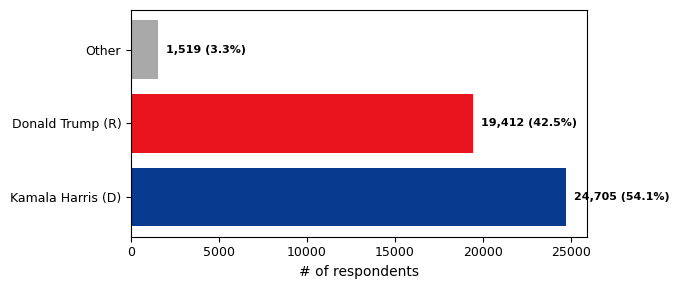

In [ ]:
# horizontal bar plot to show the breakdown of harris and trump voters in the
# 2024 ces survey dataset
# write the caption in overleaf
vote_counts = ces24_df['presvote24'].value_counts()
vote_pct = vote_counts / vote_counts.sum() * 100
colors = vote_counts.index.map({
    'Donald Trump (R)': gop_red,
    'Kamala Harris (D)': dem_blue,
    'Other': other
})
plt.figure(figsize=(7, 3))
plt.barh(vote_counts.index, vote_counts.values, color=colors)
# plt.title('CES 2024 Vote Counts and Percentages')
plt.xlabel('# of respondents')
for i, (count, pct) in enumerate(zip(vote_counts, vote_pct)):
    plt.text(count + 500, i, f'{count:,} ({pct:.1f}%)', va='center',
             color='black', fontsize=8, fontweight='bold')

plt.tight_layout()
# make x and y axis text smaller
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

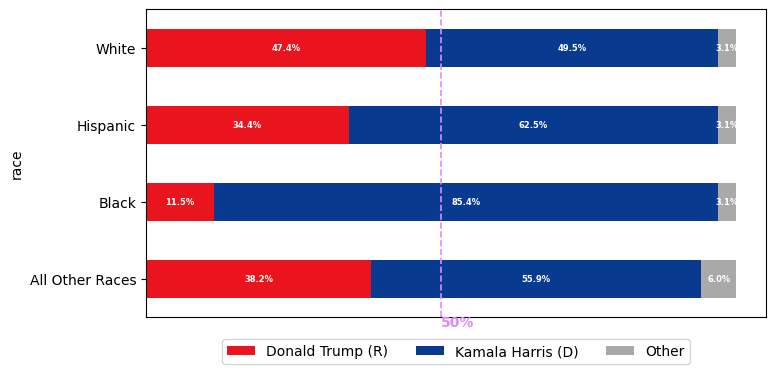

In [ ]:
# race
# make it categorical
ces24_df['race'] = pd.Categorical(ces24_df['race'])
race_vote_counts = pd.crosstab(ces24_df['race'], ces24_df['presvote24'])
race_vote_prop = race_vote_counts.div(race_vote_counts.sum(axis=1), axis=0)
race_vote_pct = race_vote_prop * 100
plot_stacked_bar(race_vote_pct)

In [ ]:
ces24_df['race'].value_counts()

,count
race,
White,34920
Black,4258
All Other Races,3737
Hispanic,2721


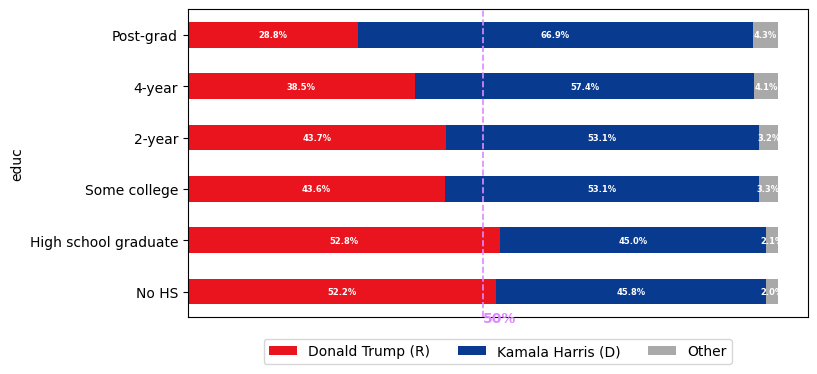

In [ ]:
# educational divide
educ_vote_counts = pd.crosstab(ces24_df['educ'], ces24_df['presvote24'])
educ_vote_prop = educ_vote_counts.div(educ_vote_counts.sum(axis=1), axis=0)
educ_vote_pct = educ_vote_prop * 100
title="Political divide by education level among 2024 CES Respondents"
plot_stacked_bar(educ_vote_pct)

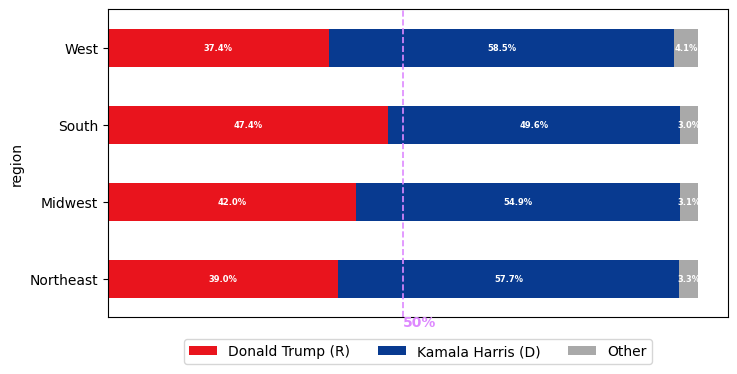

In [ ]:
# region
region_vote_counts = pd.crosstab(ces24_df['region'], ces24_df['presvote24'])
region_vote_prop = region_vote_counts.div(region_vote_counts.sum(axis=1), axis=0)
region_vote_pct = region_vote_prop * 100
plot_stacked_bar(region_vote_pct)

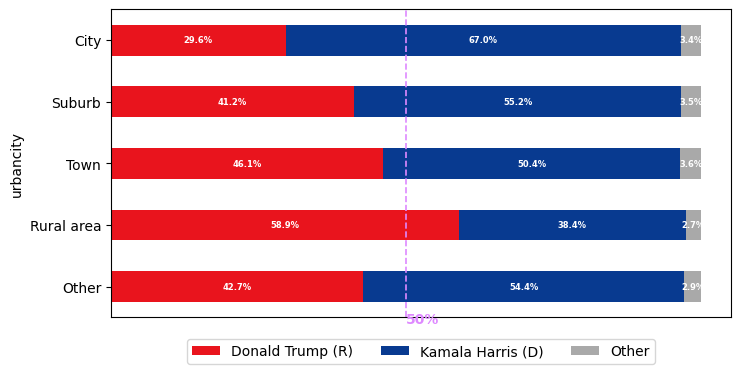

In [ ]:
# urban rural divide
urban_vote_counts = pd.crosstab(ces24_df['urbancity'], ces24_df['presvote24'])
urban_vote_prop = urban_vote_counts.div(urban_vote_counts.sum(axis=1), axis=0)
urban_vote_pct = urban_vote_prop * 100
plot_stacked_bar(urban_vote_pct.sort_index(ascending=True).iloc[::-1])

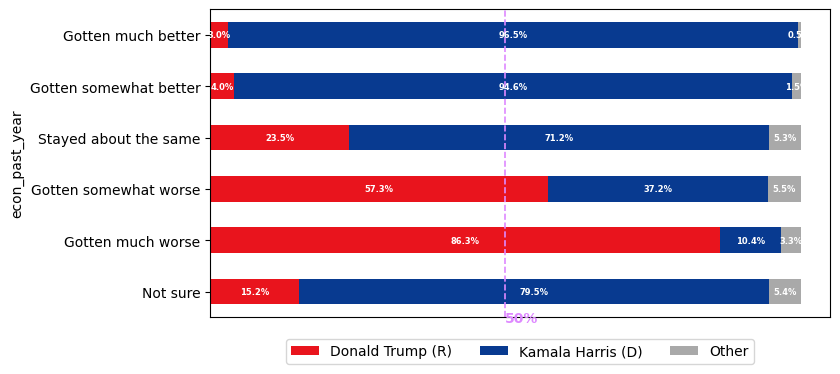

In [ ]:
# perception of the economy
econ_counts = pd.crosstab(ces24_df['econ_past_year'], ces24_df['presvote24'])
econ_prop = econ_counts.div(econ_counts.sum(axis=1), axis=0)
econ_pct = econ_prop * 100
plot_stacked_bar(econ_pct.sort_index(ascending=True).iloc[::-1])

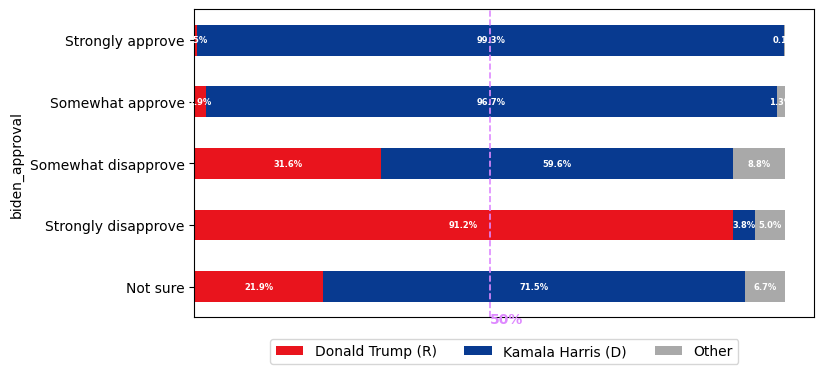

In [ ]:
# biden approval
biden_counts = pd.crosstab(ces24_df['biden_approval'], ces24_df['presvote24'])
biden_prop = biden_counts.div(biden_counts.sum(axis=1), axis=0)
biden_pct = biden_prop * 100
plot_stacked_bar(biden_pct.sort_index(ascending=True).iloc[::-1])

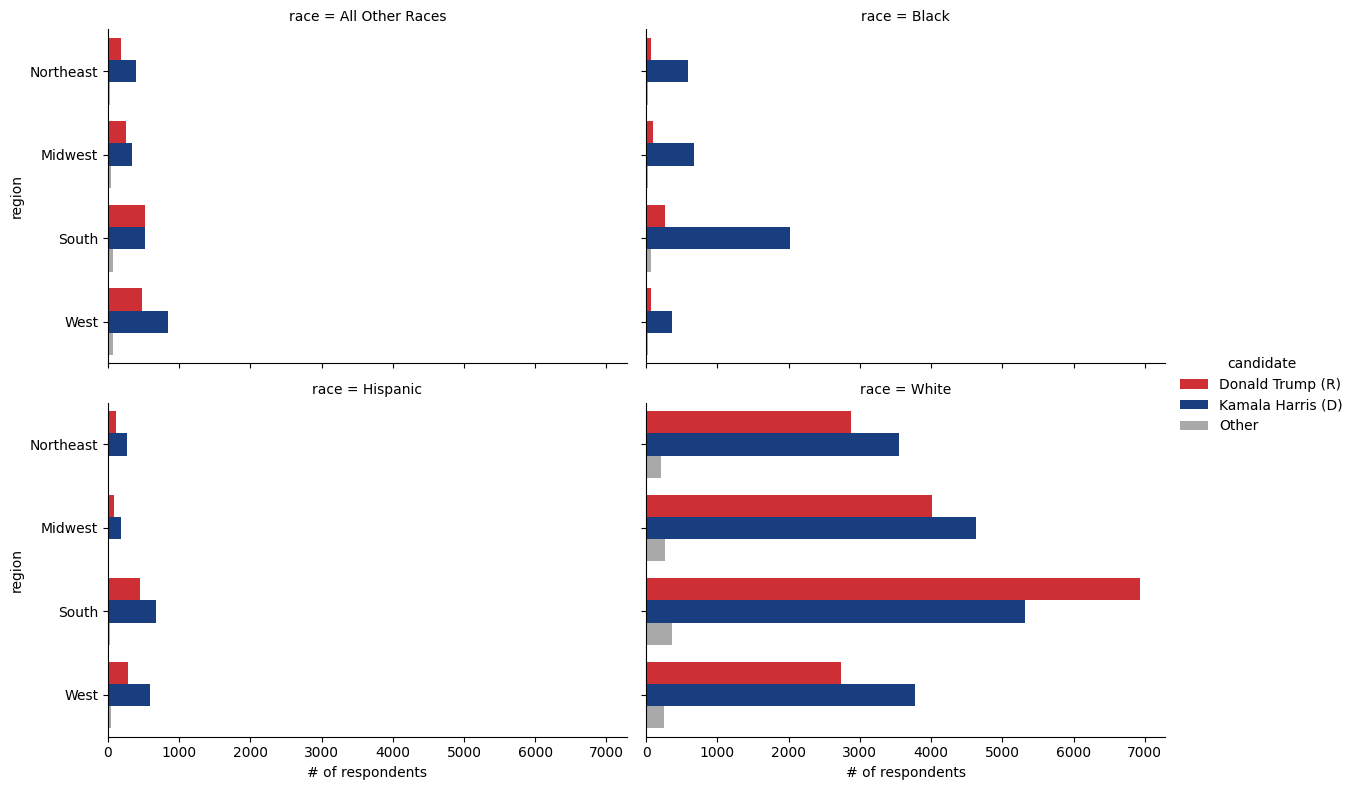

In [ ]:
# race and region
race_region_vote_counts = pd.crosstab([ces24_df['region'], ces24_df['race']], ces24_df['presvote24'])
race_region_vote_prop = race_region_vote_counts.div(race_region_vote_counts.sum(axis=1), axis=0)
race_region_vote_pct = race_region_vote_prop * 100
race_region_vote_long = race_region_vote_counts.reset_index().melt(
    id_vars=['region', 'race'],
    var_name='candidate',
    value_name='# of respondents'
)
race_region_plot = sns.catplot(
      data=race_region_vote_long,
      x='# of respondents',
      y='region',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=2,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )

# for ax in race_region_plot.axes.flat:
#     ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

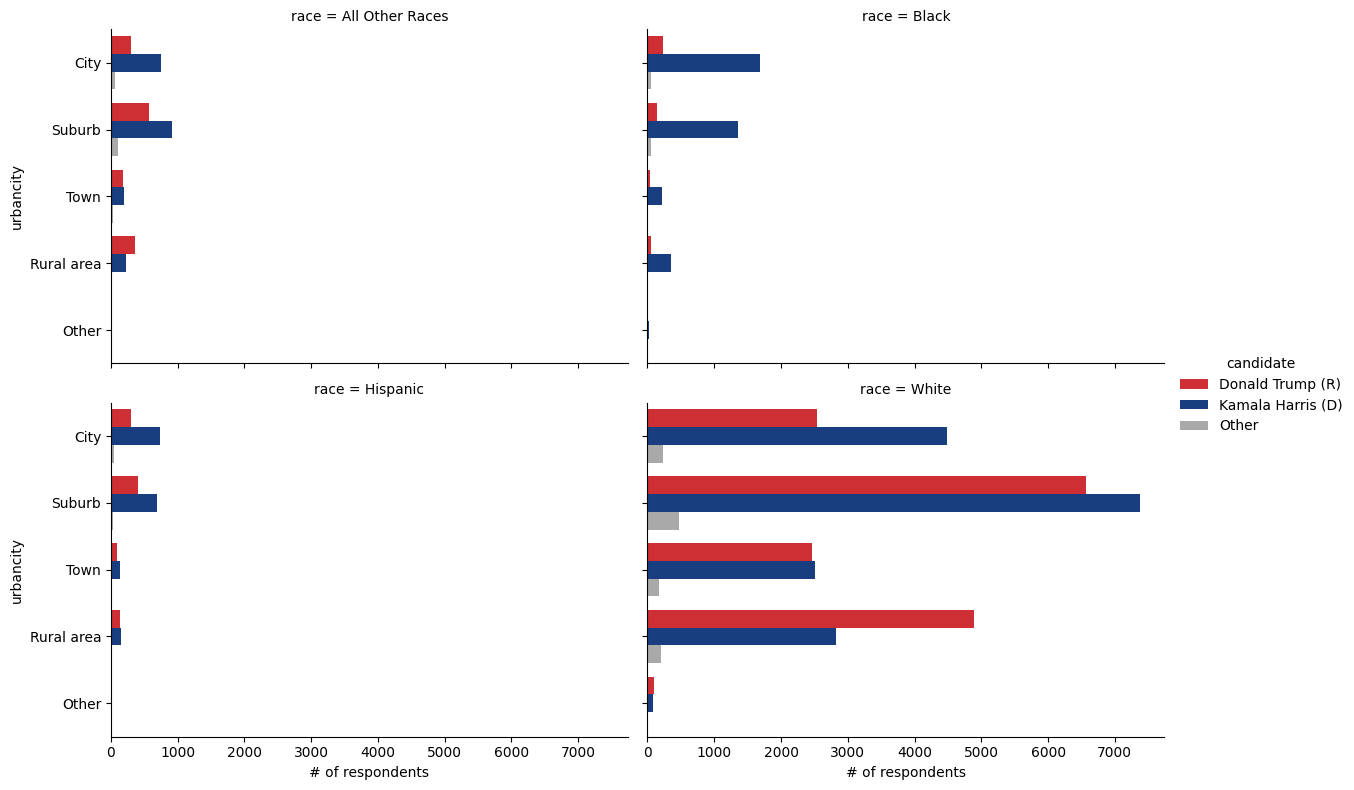

In [ ]:
# race and urban
race_urban_vote_counts = pd.crosstab([ces24_df['urbancity'], ces24_df['race']], ces24_df['presvote24'])
race_urban_vote_prop = race_urban_vote_counts.div(race_urban_vote_counts.sum(axis=1), axis=0)
race_urban_vote_pct = race_urban_vote_prop * 100
race_urban_vote_long = race_urban_vote_counts.reset_index().melt(
    id_vars=['urbancity', 'race'],
    var_name='candidate',
    value_name='# of respondents'
)
race_urban_plot = sns.catplot(
      data=race_urban_vote_long,
      x='# of respondents',
      y='urbancity',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=2,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )

# for ax in race_urban_plot.axes.flat:
#     ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

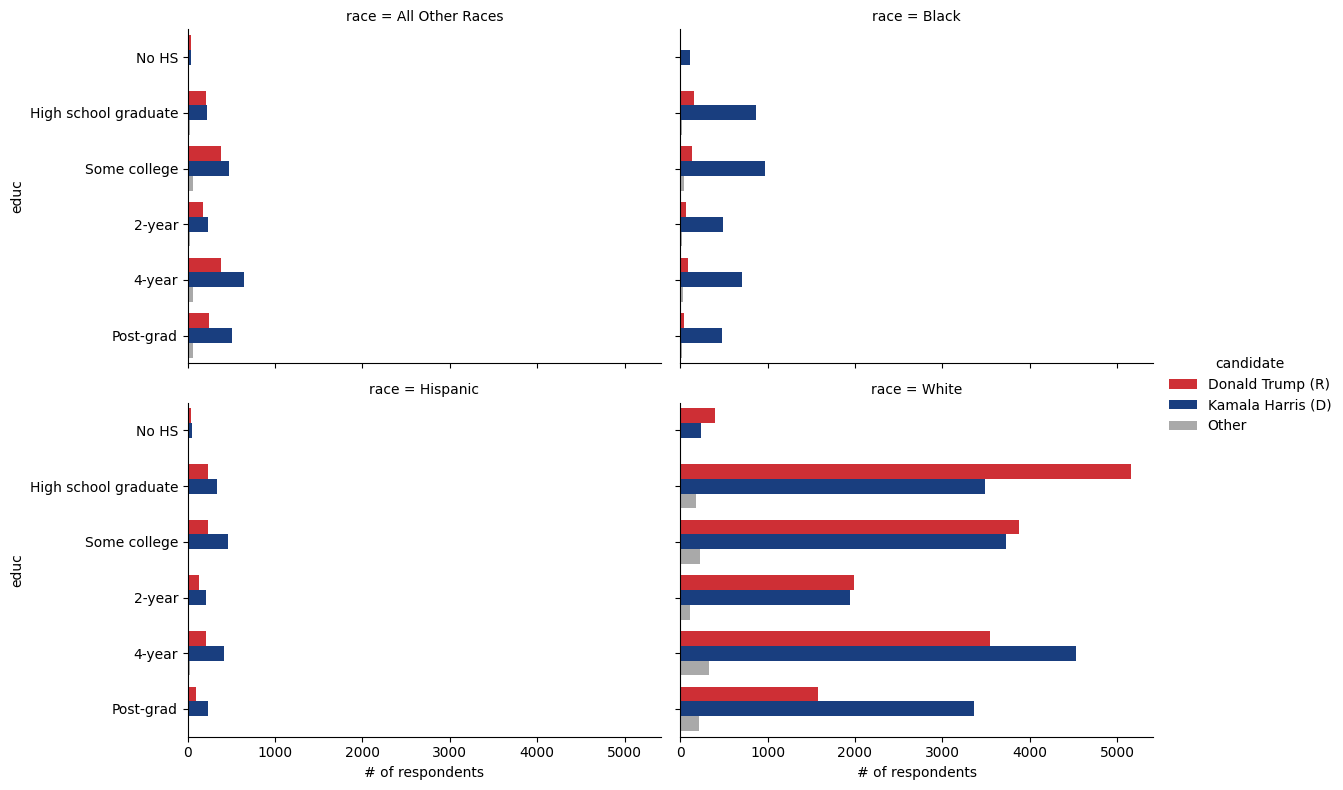

In [ ]:
# race and education
race_educ_vote_counts = pd.crosstab([ces24_df['educ'], ces24_df['race']], ces24_df['presvote24'])
race_educ_vote_prop = race_educ_vote_counts.div(race_educ_vote_counts.sum(axis=1), axis=0)
race_educ_vote_pct = race_educ_vote_prop * 100
race_educ_vote_long = race_educ_vote_counts.reset_index().melt(
    id_vars=['educ', 'race'],
    var_name='candidate',
    value_name='# of respondents'
)
race_educ_plot = sns.catplot(
      data=race_educ_vote_long,
      x='# of respondents',
      y='educ',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=2,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )


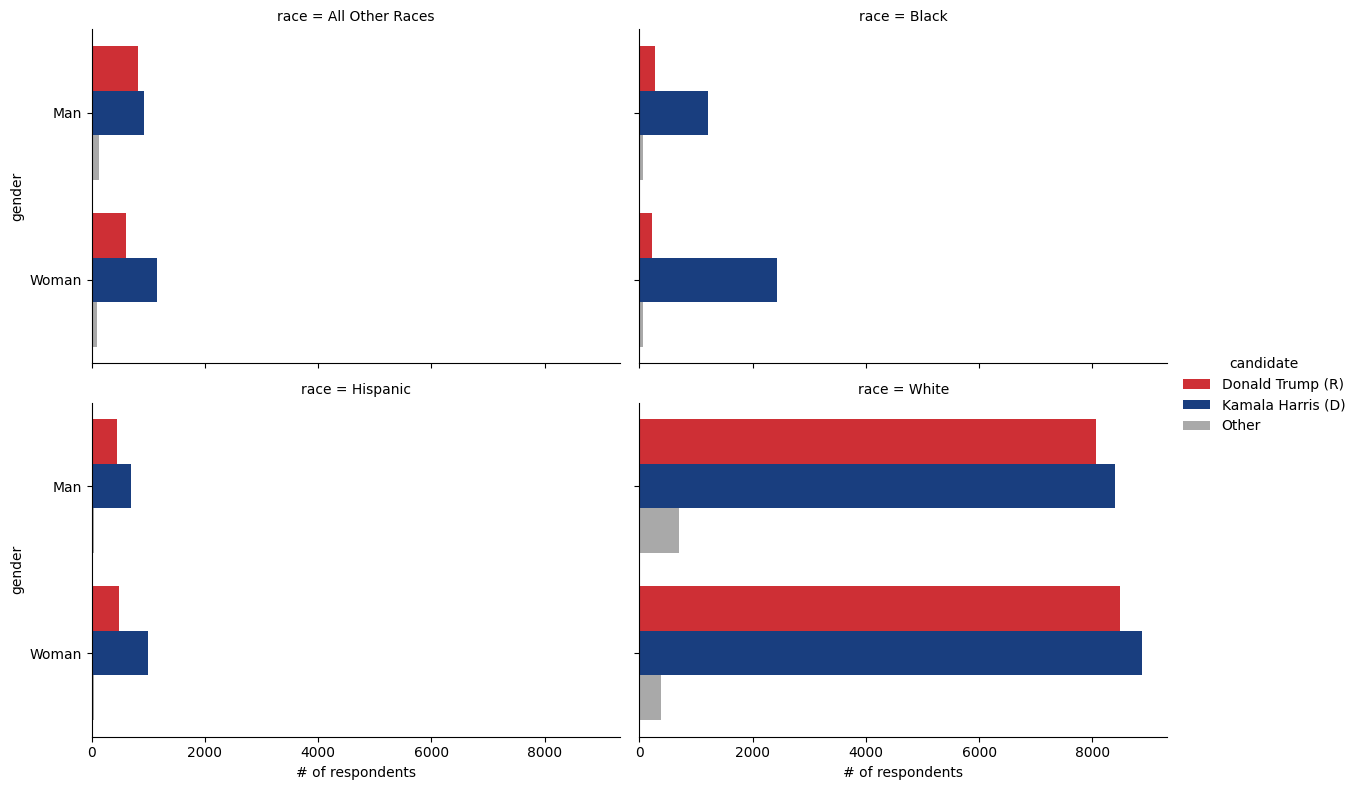

In [ ]:
# race and gender
ces24_df = ces24_df[ces24_df['gender'].isin(['Woman', 'Man'])]
ces24_df['gender'] = ces24_df['gender'].astype('category')
ces24_df['gender'] = ces24_df['gender'].cat.remove_unused_categories()
race_gender_vote_counts = pd.crosstab([ces24_df['gender'], ces24_df['race']], ces24_df['presvote24'])

race_gender_vote_long = race_gender_vote_counts.reset_index().melt(
    id_vars=['gender', 'race'],
    var_name='candidate',
    value_name='# of respondents'
)
race_gender_plot = sns.catplot(
      data=race_gender_vote_long,
      x='# of respondents',
      y='gender',
      hue='candidate',
      col='race',
      kind='bar',
      height=4,
      aspect=1.5,
      col_wrap=2,
      legend=True,
      palette={
          'Kamala Harris (D)': dem_blue,
          'Donald Trump (R)': gop_red,
          'Other': other
      }
    )

#### Under-representation of Trump voters in 2024 CES survey dataset

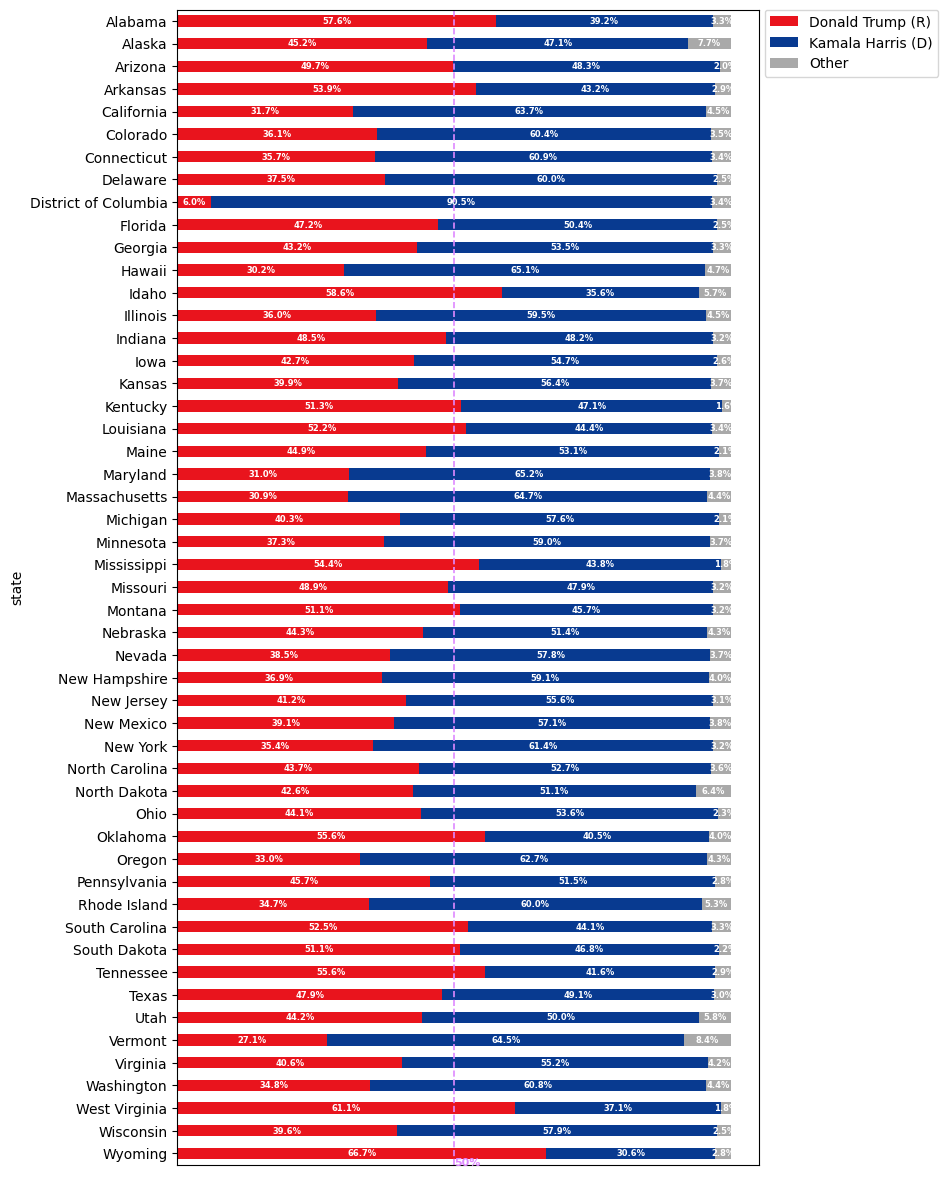

In [ ]:
# state
state_vote_counts = pd.crosstab(ces24_df['state'], ces24_df['presvote24'])
state_vote_prop = state_vote_counts.div(state_vote_counts.sum(axis=1), axis=0)
state_vote_pct = state_vote_prop * 100
# state_vote_pct = state_vote_pct.sort_index()
# state_vote_pct
title = "2024 CES Presidential Vote % By Candidate"
plot_stacked_bar(state_vote_pct.sort_index(ascending=True).iloc[::-1],
                 figsize=(7.5, 15),
                 label_fontsize=8,
                 tick_fontsize=8,
                 legend_fontsize=9,
                #  title=title,
                 legend_position=(1.16, 1),
                 legend_ncol=1)

In [ ]:
# state by state df
state_vote_pct.columns.name = None
ces_state_vote_pct_df = state_vote_pct.reset_index()
ces_state_vote_pct_df = ces_state_vote_pct_df.rename(columns={'index': 'state'})
ces_state_vote_pct_df

,state,Donald Trump (R),Kamala Harris (D),Other
0,Alabama,57.566303,39.157566,3.276131
1,Alaska,45.192308,47.115385,7.692308
2,Arizona,49.743590,48.290598,1.965812
3,Arkansas,53.947368,43.157895,2.894737
4,California,31.734523,63.720022,4.545455
5,Colorado,36.065574,60.403531,3.530895
6,Connecticut,35.681818,60.909091,3.409091
7,Delaware,37.500000,60.000000,2.500000
8,District of Columbia,6.034483,90.517241,3.448276
9,Florida,47.163647,50.371250,2.465102


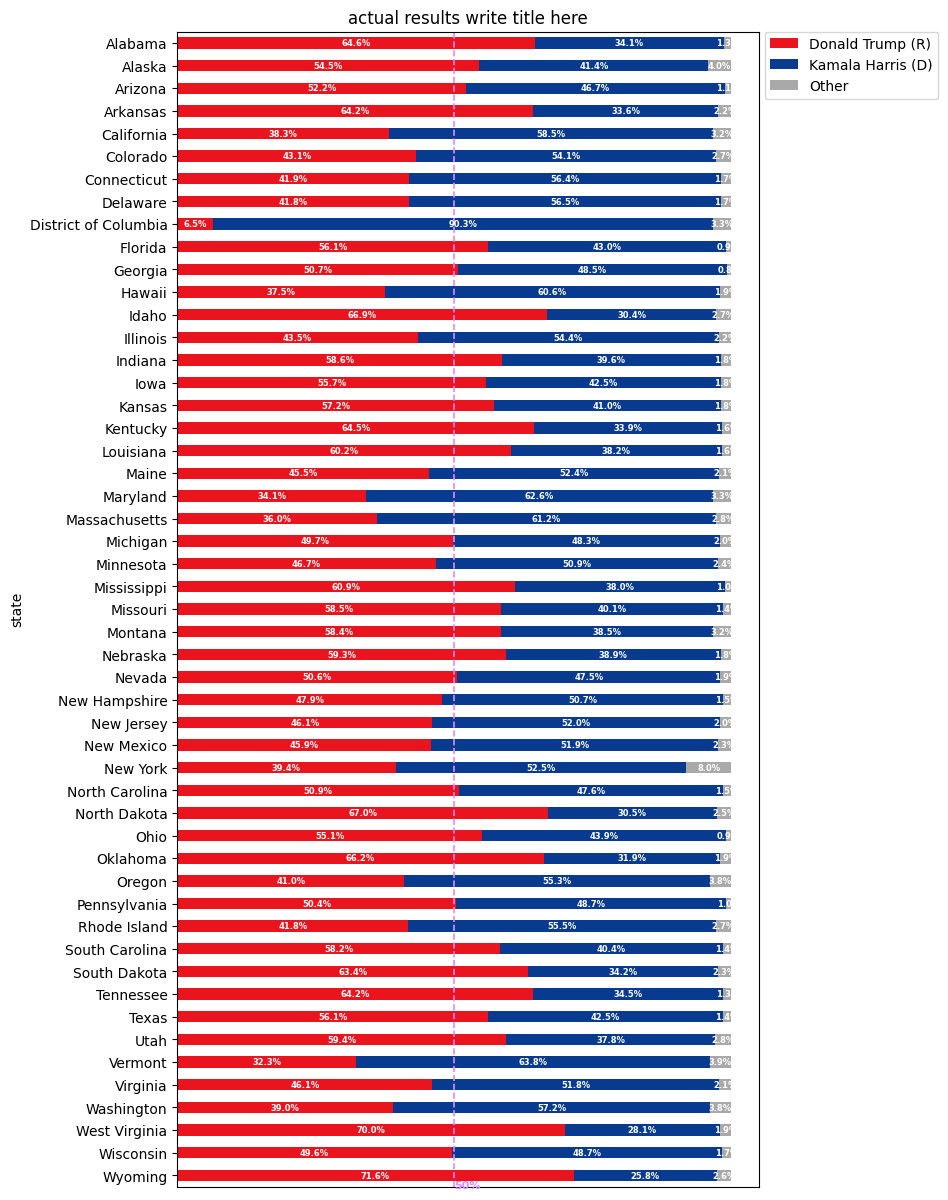

In [ ]:
actual_state_vote_pct = results24_df[['state', 'candidate_name', 'votes', 'percent']]
actual_state_vote_pct = actual_state_vote_pct[~actual_state_vote_pct['state'].str.contains('CD')]
actual_state_vote_pct = actual_state_vote_pct[actual_state_vote_pct['state'] != 'Puerto Rico']
actual_state_vote_pct = actual_state_vote_pct.pivot(index='state', columns='candidate_name', values='percent')
actual_state_vote_pct = actual_state_vote_pct.rename(columns={'Donald Trump': 'Donald Trump (R)', 'Kamala Harris': 'Kamala Harris (D)'})
actual_state_vote_pct.columns.name = None
actual_state_vote_pct['Other'] = 100 - actual_state_vote_pct['Donald Trump (R)'] - actual_state_vote_pct['Kamala Harris (D)']
title="actual results write title here"
plot_stacked_bar(actual_state_vote_pct.sort_index(ascending=True).iloc[::-1],
                 figsize=(7.5, 15),
                 label_fontsize=8,
                 tick_fontsize=8,
                 legend_fontsize=9,
                 title=title,
                 legend_position=(1.16, 1),
                 legend_ncol=1)

In [ ]:
actual_state_vote_pct

,Donald Trump (R),Kamala Harris (D),Other
state,,,
Alabama,64.572092,34.100720,1.327188
Alaska,54.544809,41.406128,4.049063
Arizona,52.217048,46.689818,1.093134
Arkansas,64.196872,33.559910,2.243218
California,38.332902,58.467704,3.199394
Colorado,43.142844,54.127686,2.729469
Connecticut,41.893906,56.398372,1.707722
Delaware,41.790989,56.492732,1.716279
District of Columbia,6.467630,90.277075,3.255296


##### How this can be addressed
For the purposes of simplicity, I will down-sample Harris voters in the 2024 CES survey dataset. My next step will to be to examine different Bayesian methods for upsampling Trump voters.

## Models
Build logistic regression model to classify Trump and Harris voters.
Use the findings of Algara et al. and Kuriwaki et al. to choose variables that explain 2024 voting behavior.

**Model 0 (full model)**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{biden\_approval}
  + \beta_8 \cdot \text{econ\_past\_year}
  + \beta_9 \cdot \text{price\_change\_past\_year}
  + \beta_{10} \cdot \text{family\_income\_past\_year}
  + \beta_{11} \cdot (\text{race} \times \text{region})
  + \beta_{12} \cdot (\text{race} \times \text{urbancity})
  + \beta_{13} \cdot (\text{race} \times \text{educ})
  + \beta_{14} \cdot (\text{race} \times \text{gender})
\big)
\end{align*}

**Model 1**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{econ\_past\_year}
  + \beta_8 \cdot \text{price\_change\_past\_year}
  + \beta_9 \cdot \text{family\_income\_past\_year}
  + \beta_{10} \cdot (\text{race} \times \text{region})
  + \beta_{11} \cdot (\text{race} \times \text{urbancity})
  + \beta_{12} \cdot (\text{race} \times \text{educ})
  + \beta_{13} \cdot (\text{race} \times \text{gender})
\big)
\end{align*}

**Model 2**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{biden\_approval}
  + \beta_8 \cdot (\text{race} \times \text{region})
  + \beta_9 \cdot (\text{race} \times \text{urbancity})
  + \beta_{10} \cdot (\text{race} \times \text{educ})
  + \beta_{11} \cdot (\text{race} \times \text{gender})
\big)
\end{align*}

**Model 3**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{biden\_approval}
  + \beta_8 \cdot \text{econ\_past\_year}
  + \beta_9 \cdot \text{price\_change\_past\_year}
  + \beta_{10} \cdot \text{family\_income\_past\_year}
  + \beta_{11} \cdot (\text{race} \times \text{educ})
  + \beta_{12} \cdot (\text{race} \times \text{gender})
\big)
\end{align*}

**Model 4**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{biden\_approval}
  + \beta_8 \cdot \text{econ\_past\_year}
  + \beta_9 \cdot \text{price\_change\_past\_year}
  + \beta_{10} \cdot \text{family\_income\_past\_year}
  + \beta_{11} \cdot (\text{race} \times \text{region})
  + \beta_{12} \cdot (\text{race} \times \text{urbancity})
\big)
\end{align*}


### Frequentist model selection

In [ ]:
# Create interaction terms
race_gender_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['gender'])
race_educ_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['educ'])
race_region_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['region'])
race_urban_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['urbancity'])

# ces24_binary = ces24_df[ces24_df['presvote24'] != 'Other']
ces24_dummies = pd.concat([
    pd.get_dummies(ces24_df, drop_first=True),
    race_gender_interaction_terms,
    race_educ_interaction_terms,
    race_region_interaction_terms,
    race_urban_interaction_terms,
], axis=1)

# make it binary (remove third party voters for modeling part)
ces24_dummies[ces24_dummies['presvote24_Other'] == 0]

# drop the presvote24 related columns
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Other'])
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Kamala Harris (D)'])
ces24_dummies = ces24_dummies.drop(columns=['birthyr'])
ces24_dummies

,vote_trump,commonweight,commonpostweight,race_Black,race_Hispanic,race_White,age_bracket_25–34,age_bracket_35–44,age_bracket_45–54,age_bracket_55–64,...,Black_Rural area,Black_Other,Hispanic_Suburb,Hispanic_Town,Hispanic_Rural area,Hispanic_Other,White_Suburb,White_Town,White_Rural area,White_Other
0,0,0.418897,0.180057,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0.946650,0.700897,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0,0.194303,0.046275,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0.083223,0.008897,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0.596598,0.555395,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59993,0,0.834862,5.484041,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59995,1,0.255305,2.469711,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59996,0,0.964466,0.931537,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
59997,0,0.246773,0.195502,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Frequentist model selection

# fit frequentist models

# full model
formula0 = "vote_trump ~ C(age_bracket) + C(gender) + C(educ) + C(state) + C(region) \
+ C(urbancity) + C(biden_approval) + C(econ_past_year) + \
C(price_change_past_year) + C(family_income_past_year)\
+ C(race):C(region) + C(race):C(urbancity) + C(race):C(educ) + C(race):C(gender)"
model0 = smf.logit(formula=formula0, data=ces24_df)
result0 = model0.fit()

# remove biden approval
formula1 = "vote_trump ~ C(age_bracket) + C(gender) + C(educ) + C(state) +C(region) \
+ C(urbancity) + C(econ_past_year) + C(price_change_past_year) + C(family_income_past_year)\
+ C(race):C(region) + C(race):C(urbancity) + C(race):C(educ) + C(race):C(gender)"
model1 = smf.logit(formula=formula1, data=ces24_df)
result1 = model1.fit()

# remove economy/inflation/cost of living
formula2 = "vote_trump ~ C(age_bracket) + C(gender) + C(educ) + C(state) + C(region) \
+ C(urbancity) + C(biden_approval) + \
+ C(race):C(region) + C(race):C(urbancity) + C(race):C(educ) + C(race):C(gender)"
model2 = smf.logit(formula=formula2, data=ces24_df)
result2 = model2.fit()

# remove race and geography-related interactions (maybe try just removing the race related interactions here)
formula3 = "vote_trump ~ C(age_bracket) + C(gender) + C(educ) + C(state) + C(region) \
+ C(urbancity) + C(biden_approval) + C(econ_past_year) + \
C(price_change_past_year) + C(family_income_past_year)\
+ C(race):C(educ) + C(race):C(gender)"
model3 = smf.logit(formula=formula3, data=ces24_df)
result3 = model3.fit()

# remove race and demographic interactions
formula4 = "vote_trump ~ C(age_bracket) + C(gender) + C(educ) + C(state) + C(region) \
+ C(urbancity) + C(biden_approval) + C(econ_past_year) + \
C(price_change_past_year) + C(family_income_past_year)\
+ C(race):C(region) + C(race):C(urbancity)"
model4 = smf.logit(formula=formula4, data=ces24_df)
result4 = model4.fit()

Optimization terminated successfully.
         Current function value: 0.193903
         Iterations 9
         Current function value: 0.346076
         Iterations: 35


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.203196
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.194430
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.194745
         Iterations 9


In [ ]:
def likelihood_ratio(full_model, reduced_model):
  """
  Calculates likelihood ratio test statistic for comparing two nested
  generalized linear models (GLMs).

  Parameters
    - full_model: the full (more complex) model
    - reduced_model: the reduced (simpler) model where its parameters are a
    subset of those in full_model

  Returns
    - likelihood ratio test statistic (float)
    - difference in degrees of freedom between full and reduced models (int)
    - p-value for the likelihood ratio test (float)
  """
  lr_stat = 2 * (full_model.llf - reduced_model.llf)
  df_diff = int(full_model.df_model - reduced_model.df_model)
  p_value = 1 - chi2.cdf(lr_stat, df_diff)
  print(f'LR stat: {lr_stat:.4f}, full df - reduced df: {df_diff}, p-value: {p_value}')

In [ ]:
# model 0 fits the data significantly better than model 1
likelihood_ratio(result0, result1)

LR stat: 13889.1241, full df - reduced df: 4, p-value: 0.0


In [ ]:
# model 0 vs model 2
likelihood_ratio(result0, result2)

LR stat: 848.2705, full df - reduced df: 13, p-value: 0.0


In [ ]:
# model 0 vs model 3
likelihood_ratio(result0, result3)

LR stat: 48.1516, full df - reduced df: 21, p-value: 0.0006556991250059596


In [ ]:
# model 0 vs model 4
# model 0 does not significantly improve fit over model 4???
likelihood_ratio(result0, result4)

LR stat: 76.8410, full df - reduced df: 18, p-value: 3.0415691076868256e-09


### ML Logistic model performance

In [ ]:
# model 0
X = ces24_dummies.drop(columns=['vote_trump'])
y = ces24_dummies['vote_trump']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# fit the model
model0 = LogisticRegression()
model0.fit(X_train, y_train)

# make predictions
y_pred = model0.predict(X_test)

# evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
model0_performance = classification_report(y_test, y_pred)

# model in previous assignment had lower performance on positive class because it was probably bad
# comparable precision, recall, f1-score across both classes

In [ ]:
# tensorflow framework


## Results

resource used: https://www.tensorflow.org/guide/core/logistic_regression_core

In [ ]:
# before regularization and gradient descent
print(model0_performance)

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# train_dataset = ces24_df.sample(frac=0.75, random_state=0)
# test_dataset = ces24_df.drop(train_dataset.index)
# train and test dummy data
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_dataset = ces24_dummies.sample(frac=0.75, random_state=0)
test_dataset = ces24_dummies.drop(train_dataset.index)

# feature matrices and target vectors
X_train, y_train = train_dataset.drop(columns=['vote_trump']), train_dataset['vote_trump']
X_test, y_test = test_dataset.drop(columns=['vote_trump']), test_dataset['vote_trump']

# define the logistic model architecture
logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train.shape[1],)
                       # kernel_regularizer = regularizers.l2(0.01) # l2 regularization and lambda penalty
                       )
])

# compile model using adam optimizer, binary cross entropy loss, and accuracy metric
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) # learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'loss']
)

# fit it
history = logistic_model.fit(X_train, y_train,
                             epochs=100,
                             batch_size=32,
                             validation_data=(X_test, y_test)
                             verbose=0)

y_pred_prob = logistic_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      6498
           1       0.90      0.93      0.92      4911

    accuracy                           0.93     11409
   macro avg       0.93      0.93      0.93     11409
weighted avg       0.93      0.93      0.93     11409



## Appendix

### Model training and optimization

In [ ]:
# hyperparameter tuning

In [ ]:
# L2 regularization

In [ ]:
# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training and Validation Loss vs Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# accuracy

### Intervals for coefficients

### Bayesian Posterior Analysis and Markov Chain Monte Carlo (MCMC) Diagnostics



In [ ]:
# refit the model in PyMc
model = pm.Model()

In [ ]:
# posterior estimates

In [ ]:
# posterior predictive checks